In [56]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os 

In [41]:
# Follow: https://kikaben.com/gangenerative-adversarial-network-simple-implementation-with-pytorch/

transform = transforms.ToTensor()
dataset = datasets.MNIST(
    root = './data', 
    train = True, # training set  
    download = True, 
    transform = transform 
)
dataloader = DataLoader(
    dataset, 
    batch_size = 64, 
    drop_last = True # Discard the last non divisible batch 
)

images, labels = next(iter(dataloader))

print(images.shape)
print(labels)
# Tensor[64, 1, 28, 28] -> 64 = Batch size. 1 = Color channel. 28x28 image. 

torch.Size([64, 1, 28, 28])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])


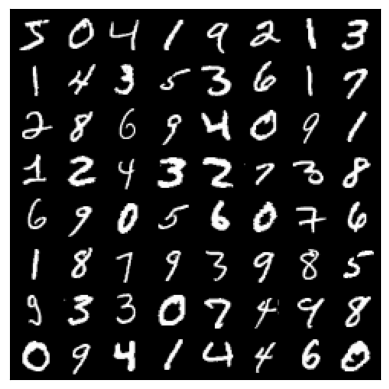

In [42]:
def show_image_grid(images: torch.Tensor, ncol: int): 
    image_grid = make_grid(
        images, 
        ncol
    ) # Make images into a grid 

    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last 
    image_grid = image_grid.cpu().numpy() 

    plt.imshow(image_grid)
    plt.xticks([]) # Empty x and y labels 
    plt.yticks([])
    plt.show() 


show_image_grid(
    images = images, 
    ncol = 8
)

In [43]:
# Generator. 
# Random value vector as input i.e. random values into image
# Standard normal diitribution as init
z = torch.randn(1, 100)
print(z)

tensor([[ 0.1269,  1.1767, -1.1205, -1.3349, -0.8568, -0.8108, -0.5566, -0.7352,
          0.5010, -0.3840, -2.6364, -0.3324,  0.5843, -0.9719,  0.3706, -0.5241,
         -0.2034, -0.9961, -1.3797, -0.2515, -0.3378,  0.1243,  0.2792,  1.1001,
         -1.2790,  0.0707,  1.3289, -0.3653,  0.5974,  0.0069, -1.3287,  1.2618,
         -1.4216,  1.4294,  1.8326, -0.4540, -0.1928,  0.5651, -1.3296,  0.2691,
          1.7622,  0.1320,  0.2494,  0.9316, -0.2843,  0.2211, -0.2711,  0.2891,
         -0.4050,  0.1776, -1.0670, -0.1251, -2.0343, -0.3535,  0.2477, -0.6772,
         -0.2478, -0.6937,  0.4639,  1.3443, -0.5249, -0.1490, -0.8147, -0.9168,
          1.5783, -0.0255,  1.0764, -0.4947,  0.6059, -1.1001, -0.5912, -0.1302,
          0.3408,  1.1422,  0.3595, -0.6412,  1.1412,  0.5470, -0.8462, -1.3403,
         -0.0602,  0.1716,  0.8224,  1.8729, -0.0634,  0.9522,  0.1509,  1.8542,
          0.7506, -1.6168, -1.6168, -0.7002,  1.9505, -1.0474, -0.7975, -0.2915,
          1.3390,  1.1248,  

In [48]:
generator_test = nn.Sequential(
    nn.Linear(
        in_features = 100,
        out_features = 128
    ),
    nn.LeakyReLU(0.01),
    nn.Linear(
        in_features = 128,
        out_features = 784 # 784 = 28x28 image 
    ),
    nn.Sigmoid() # Squeeze the ouput values between 0 and 1 i.e. grayscale.
)

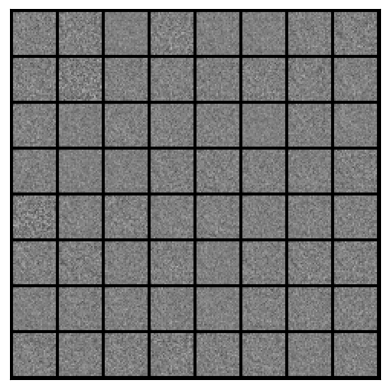

In [49]:
def generate_images():
    z = torch.randn(64, 100)
    output = generator_test(z)
    # Reshape the output to 64 images 
    generated_images = output.reshape(64, 1, 28 ,28)
    return generated_images

generated_images_test = generate_images()
show_image_grid(
    generated_images_test, 
    ncol = 8
)

# Output should be random noise since the generator has not been trained.

In [84]:
# Discriminator: Real or Fake
# Fake = Does not look like it is from MNIST 
# Real = Looks like it is from MNIST

epochs = 100
batch_size = 64
sample_size = 100 # Number of random values to sample 
g_lr = 1.0e-4 # Generator learning rate
d_lr = 1.0e-4 # Discriminator learning rate

class Generator(nn.Sequential):
    def __init__(self, sample_size: int):
        super().__init__(
            nn.Linear(sample_size, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
        # Random value vector size
        self.sample_size = sample_size

    def forward(self, batch_size: int, z): 
        output = super().forward(z)
        generated_images = output.reshape(batch_size, 1, 28, 28) 
        return generated_images


class Discriminator(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1)
        )

    def forward(self, images: torch.Tensor, targets: torch.Tensor):
        prediction = super().forward(images.reshape(-1, 784))
        loss = F.binary_cross_entropy_with_logits(prediction, targets)
        return loss

folder_path = "/home/magnusjsc/repos/Classification-and-3D-reconstruction-of-archaeological-artifacts/data/MNIST Result Images" 
def save_images_grid(epoch: int, images: torch.Tensor, ncol: int):
    image_grid = make_grid(images, ncol)     # Images in a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel last
    image_grid = image_grid.cpu().numpy()    # To Numpy

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(folder_path, f'generated_{epoch:03d}.jpg'))
    plt.close()


In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

generator = Generator(sample_size).to(device)
discriminator = Discriminator().to(device)

real_targets = torch.ones(batch_size, 1).to(device)
fake_targets = torch.zeros(batch_size, 1).to(device)

# Adam optimizer. https://kikaben.com/gradient-descent-optimizers/#adam 
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = d_lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr = g_lr)

# Training 
for epoch in range(epochs):
    d_losses = []
    g_losses = []

    # Discriminator training 
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        discriminator.train()
        d_loss = discriminator(images, real_targets)

        generator.eval()
        with torch.no_grad(): 
            z = torch.randn(batch_size, sample_size).to(device) 
            generated_images = generator(batch_size, z)
            generated_images = generated_images.to(device)  

        d_loss += discriminator(generated_images, fake_targets)

        d_optimizer.zero_grad()
        d_loss.backward() 
        d_optimizer.step() 


    # Generator training 
        generator.train() 
        z = torch.randn(batch_size, sample_size).to(device)
        generated_images = generator(batch_size, z)
        generated_images = generated_images.to(device)  
        
        discriminator.eval() 
        g_loss = discriminator(generated_images, real_targets)

        g_optimizer.zero_grad() 
        g_loss.backward() 
        g_optimizer.step() 

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    print(epoch, np.mean(d_losses), np.mean(g_losses))

    save_images_grid(epoch, generated_images, ncol=8) 


Using device: cuda


100%|██████████| 937/937 [00:06<00:00, 140.02it/s]


0 0.42591081697219463 2.7475096070015823


100%|██████████| 937/937 [00:06<00:00, 143.73it/s]


1 0.39395722180700354 2.083091258239339


100%|██████████| 937/937 [00:06<00:00, 141.02it/s]


2 0.5359120203883824 1.565011337447192


100%|██████████| 937/937 [00:06<00:00, 140.40it/s]


3 0.6657570854958501 1.133351964146503


100%|██████████| 937/937 [00:06<00:00, 140.54it/s]


4 0.4692055025757186 1.4403216263782253


100%|██████████| 937/937 [00:06<00:00, 140.45it/s]


5 0.501763825896201 1.7008294917984985


100%|██████████| 937/937 [00:06<00:00, 140.94it/s]


6 0.7241411620041349 1.6585583689373102


100%|██████████| 937/937 [00:06<00:00, 138.93it/s]


7 0.6718683478163044 1.6621807174977778


100%|██████████| 937/937 [00:06<00:00, 140.76it/s]


8 0.5428232609462331 1.8104447819761686


100%|██████████| 937/937 [00:06<00:00, 140.80it/s]


9 0.5881493053415924 1.8045892500444818


100%|██████████| 937/937 [00:06<00:00, 144.08it/s]


10 0.5837619373994296 1.7974180899154923


100%|██████████| 937/937 [00:06<00:00, 145.07it/s]


11 0.44052561166573995 2.128268926985872


100%|██████████| 937/937 [00:06<00:00, 141.27it/s]


12 0.47836096554581103 2.0248281698725648


100%|██████████| 937/937 [00:06<00:00, 143.58it/s]


13 0.4475066182516682 2.01627071919029


100%|██████████| 937/937 [00:06<00:00, 140.65it/s]


14 0.3429787077065339 2.3192904841556365


100%|██████████| 937/937 [00:06<00:00, 141.95it/s]


15 0.35931282691665495 2.4037235575780795


100%|██████████| 937/937 [00:06<00:00, 142.19it/s]


16 0.4224628421737392 2.343195619043698


100%|██████████| 937/937 [00:07<00:00, 131.62it/s]


17 0.39769502221074915 2.40648630728971


100%|██████████| 937/937 [00:07<00:00, 130.90it/s]


18 0.3695681659522662 2.435991531375124


100%|██████████| 937/937 [00:07<00:00, 132.53it/s]


19 0.42191698538137473 2.3548668540274704


100%|██████████| 937/937 [00:07<00:00, 132.82it/s]


20 0.4403046947310548 2.378393140521095


100%|██████████| 937/937 [00:07<00:00, 133.64it/s]


21 0.4440377303255024 2.318092888549145


100%|██████████| 937/937 [00:07<00:00, 132.80it/s]


22 0.427624730268054 2.3660996630708335


100%|██████████| 937/937 [00:07<00:00, 128.95it/s]


23 0.425745443352513 2.3543614982413636


100%|██████████| 937/937 [00:07<00:00, 132.57it/s]


24 0.42310266576810734 2.387093945144971


100%|██████████| 937/937 [00:07<00:00, 131.00it/s]


25 0.4790166530245269 2.294919717400916


100%|██████████| 937/937 [00:07<00:00, 132.27it/s]


26 0.49224421757262443 2.263992817323007


100%|██████████| 937/937 [00:06<00:00, 133.93it/s]


27 0.4995063621880787 2.2699538560916164


100%|██████████| 937/937 [00:07<00:00, 133.00it/s]


28 0.4586548008334802 2.3540763436412098


100%|██████████| 937/937 [00:07<00:00, 133.74it/s]


29 0.42838931945624703 2.450134298971903


100%|██████████| 937/937 [00:07<00:00, 133.21it/s]


30 0.41777482841923247 2.5009020298496765


100%|██████████| 937/937 [00:06<00:00, 134.49it/s]


31 0.4704147048350205 2.391094082193161


100%|██████████| 937/937 [00:06<00:00, 134.82it/s]


32 0.46137900349933536 2.405334235509915


100%|██████████| 937/937 [00:06<00:00, 134.32it/s]


33 0.4907761351498621 2.389130066782077


100%|██████████| 937/937 [00:06<00:00, 133.88it/s]


34 0.5052534678797839 2.340981605849373


100%|██████████| 937/937 [00:07<00:00, 133.77it/s]


35 0.5018088420338157 2.374111611280777


100%|██████████| 937/937 [00:06<00:00, 134.55it/s]


36 0.5373649344309417 2.28102996954923


100%|██████████| 937/937 [00:06<00:00, 135.50it/s]


37 0.5378435863820059 2.2780960463663305


100%|██████████| 937/937 [00:06<00:00, 135.49it/s]


38 0.5211475725616691 2.2859135941227575


100%|██████████| 937/937 [00:06<00:00, 134.76it/s]


39 0.48526097256829415 2.3752175583528987


100%|██████████| 937/937 [00:06<00:00, 134.46it/s]


40 0.4960996016239789 2.3890105466832474


100%|██████████| 937/937 [00:07<00:00, 133.70it/s]


41 0.5071140375373967 2.3548894194426886


100%|██████████| 937/937 [00:06<00:00, 134.67it/s]


42 0.47730385123283914 2.4176258706232274


100%|██████████| 937/937 [00:07<00:00, 133.57it/s]


43 0.48361503041032283 2.434804876433365


100%|██████████| 937/937 [00:06<00:00, 134.51it/s]


44 0.47469587889654025 2.4727739616035778


100%|██████████| 937/937 [00:07<00:00, 132.41it/s]


45 0.47481393276563705 2.4717259320530847


100%|██████████| 937/937 [00:07<00:00, 133.10it/s]


46 0.5068950021724945 2.424510631769927


100%|██████████| 937/937 [00:07<00:00, 133.22it/s]


47 0.4300621753059558 2.6395514563537077


100%|██████████| 937/937 [00:07<00:00, 133.42it/s]


48 0.4738972072699281 2.57704430252409


100%|██████████| 937/937 [00:07<00:00, 133.48it/s]


49 0.5178041223559843 2.444141739078876


100%|██████████| 937/937 [00:07<00:00, 133.48it/s]


50 0.5344913740231871 2.395662786357558


100%|██████████| 937/937 [00:06<00:00, 140.69it/s]


51 0.5402776303451624 2.3447949587344614


100%|██████████| 937/937 [00:06<00:00, 141.86it/s]


52 0.5289685368029005 2.376818673842236


100%|██████████| 937/937 [00:06<00:00, 144.88it/s]


53 0.674852591393597 2.152801573340132


100%|██████████| 937/937 [00:06<00:00, 144.65it/s]


54 0.4335274680765105 2.633510967201713


100%|██████████| 937/937 [00:07<00:00, 129.65it/s]


55 0.534490306419395 2.4032174127460673


100%|██████████| 937/937 [00:06<00:00, 133.93it/s]


56 0.5425520438776454 2.3344861709193716


100%|██████████| 937/937 [00:06<00:00, 136.36it/s]


57 0.6645291948267592 2.1660012329909692


100%|██████████| 937/937 [00:07<00:00, 131.67it/s]


58 0.5859999579070345 2.4167323635380193


100%|██████████| 937/937 [00:07<00:00, 131.05it/s]


59 0.6055526475609939 2.2764446295185556


100%|██████████| 937/937 [00:07<00:00, 130.17it/s]


60 0.5333097013967905 2.4340516252476987


100%|██████████| 937/937 [00:07<00:00, 130.03it/s]


61 0.5796505667929207 2.2880382201969307


100%|██████████| 937/937 [00:07<00:00, 129.35it/s]


62 0.5992281624576198 2.264766676957732


100%|██████████| 937/937 [00:07<00:00, 128.70it/s]


63 0.7330056280374782 2.0860579815338363


100%|██████████| 937/937 [00:07<00:00, 129.44it/s]


64 0.4746216034940111 2.6103325578420877


100%|██████████| 937/937 [00:07<00:00, 129.87it/s]


65 0.5785362549372646 2.3186578777327482


100%|██████████| 937/937 [00:07<00:00, 126.14it/s]


66 0.5642152515775748 2.3223641433990627


100%|██████████| 937/937 [00:07<00:00, 128.72it/s]


67 0.745896511646574 2.0924799028811867


100%|██████████| 937/937 [00:07<00:00, 130.27it/s]


68 0.6367000844269959 2.1800057721367003


100%|██████████| 937/937 [00:07<00:00, 128.41it/s]


69 0.5076356384040452 2.462153624190592


100%|██████████| 937/937 [00:07<00:00, 127.79it/s]


70 0.6029018882817113 2.2273732638791635


100%|██████████| 937/937 [00:07<00:00, 133.67it/s]


71 0.5941639078528548 2.2272482095176915


100%|██████████| 937/937 [00:07<00:00, 129.04it/s]


72 0.8576966775074331 1.9293675638949985


100%|██████████| 937/937 [00:07<00:00, 131.22it/s]


73 0.7766662891417455 2.0220890062977435


100%|██████████| 937/937 [00:07<00:00, 130.38it/s]


74 0.4952154957561127 2.532870469759979


100%|██████████| 937/937 [00:07<00:00, 128.88it/s]


75 0.6224006828210906 2.28386866206675


100%|██████████| 937/937 [00:07<00:00, 126.25it/s]


76 0.6636347061414729 2.1766052081974236


100%|██████████| 937/937 [00:07<00:00, 126.51it/s]


77 0.6533406019656101 2.145018700601706


100%|██████████| 937/937 [00:07<00:00, 133.40it/s]


78 0.659251478018603 2.0915274751097312


100%|██████████| 937/937 [00:07<00:00, 132.79it/s]


79 0.649159676523575 2.1072884621207972


100%|██████████| 937/937 [00:07<00:00, 129.75it/s]


80 0.6395495414670275 2.141088622738483


100%|██████████| 937/937 [00:06<00:00, 134.27it/s]


81 0.6525095262929494 2.1149120021655183


100%|██████████| 937/937 [00:06<00:00, 135.55it/s]


82 1.6013991326061867 1.4133201175972645


100%|██████████| 937/937 [00:07<00:00, 132.26it/s]


83 1.1658145790102643 1.6033512733662014


100%|██████████| 937/937 [00:06<00:00, 134.44it/s]


84 0.6673478995914012 2.222588691283952


100%|██████████| 937/937 [00:06<00:00, 134.43it/s]


85 0.6028832657582732 2.291759951137555


100%|██████████| 937/937 [00:07<00:00, 132.84it/s]


86 1.7067227013719248 1.218349065985471


100%|██████████| 937/937 [00:07<00:00, 133.62it/s]


87 0.6739852944331337 2.1710498395317264


100%|██████████| 937/937 [00:06<00:00, 136.20it/s]


88 0.6573915161916006 2.136447739448466


100%|██████████| 937/937 [00:07<00:00, 132.85it/s]


89 0.9574080318562377 1.696682150743051


100%|██████████| 937/937 [00:07<00:00, 133.72it/s]


90 1.0538810927623619 1.6166118057713055


100%|██████████| 937/937 [00:06<00:00, 134.79it/s]


91 0.6404611642612592 2.06332095570091


100%|██████████| 937/937 [00:07<00:00, 131.47it/s]


92 0.7401386783115382 1.981015478534149


100%|██████████| 937/937 [00:07<00:00, 132.68it/s]


93 1.7166994712141561 1.1197250475878395


100%|██████████| 937/937 [00:06<00:00, 135.52it/s]


94 0.831434537055271 1.8210456213549082


100%|██████████| 937/937 [00:06<00:00, 134.31it/s]


95 0.5843500171806921 2.1915246302951745


100%|██████████| 937/937 [00:07<00:00, 131.82it/s]


96 0.7225392106184965 1.9443082810720487


100%|██████████| 937/937 [00:07<00:00, 133.25it/s]


97 0.8692466153851696 1.766087780830827


100%|██████████| 937/937 [00:06<00:00, 135.32it/s]


98 0.6292118335991557 2.0852738555238495


100%|██████████| 937/937 [00:07<00:00, 132.80it/s]

99 0.7606010093505762 1.8894371399884544
